In [1]:
#!pip install -U transformers
#!pip install -U datasets
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
#!pip install transformers
from transformers import RobertaConfig, RobertaModel,RobertaForSequenceClassification, Trainer,AutoModelForSequenceClassification, EarlyStoppingCallback 
from transformers import AutoTokenizer
from transformers.models.roberta import RobertaPreTrainedModel
import torch
from torch import nn
from transformers import TrainingArguments
import shutil
import glob

In [2]:
all_cols =  ['Budget',
             'averageRating',
             'cast',
             'countries',
             'director',
             'genres',
             'imdb_id',
             'languages',
             'overview',
             'production companies',
             'release_date',
             'revenue_worldwide_BOM',
             'runtimeMinutes',
             'title']

categoric_cols = ['cast',
                  'countries',
                  'director',
                  'genres',
                  'languages',
                  'production companies']

text_cols = ['title','overview']                  
date_cols = ['release_date']
numeric_cols = ['Budget','runtimeMinutes']

train_ids = pd.read_csv('data/processed/train.csv',usecols=['imdb_id'])['imdb_id'].tolist()
val_ids = pd.read_csv('data/processed/val.csv',usecols=['imdb_id'])['imdb_id'].tolist()
test_ids = pd.read_csv('data/processed/test.csv',usecols=['imdb_id'])['imdb_id'].tolist()
df = pd.read_csv('data/processed/df.csv',usecols = all_cols,parse_dates=['release_date']).sample(frac=1,random_state=42) #shuffle


df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.replace('|',', '),axis=0) #Change pipe to comma, its more meaningful

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [3]:
train = df[df['imdb_id'].isin(train_ids)]
val = df[df['imdb_id'].isin(val_ids)]
test = df[df['imdb_id'].isin(test_ids)]

In [4]:
(test['revenue_worldwide_BOM'] - train['revenue_worldwide_BOM'].quantile(.5)).abs().mean()

45550301.68814139

In [2]:
import numpy as np

In [6]:
p1 = np.log1p(train['revenue_worldwide_BOM']).mean()
p2 = np.log1p(train['revenue_worldwide_BOM']).quantile(.5)

In [7]:
((np.log1p(val['revenue_worldwide_BOM'].values) - p1)**2).mean()

15.00067788636355

In [8]:
np.sqrt(((val['revenue_worldwide_BOM'].values - np.expm1(p1))**2).mean())

147582380.4185592

In [9]:
(np.abs(np.log1p(val['revenue_worldwide_BOM'].values) - p2)).mean()

3.5123012840508303

In [16]:
df.shape

(11694, 14)

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("mse")

def compute_metrics(eval_pred,metric):
    logits, labels = eval_pred
    predictions = logits
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
preds = trainer.predict(test_dataset)

In [ ]:
eval_preds = [preds.predictions,preds.label_ids]
compute_metrics(eval_preds,metric)

In [ ]:
y_bar = preds.label_ids.mean()
eval_preds = [preds.predictions,preds.label_ids]

1-compute_metrics(eval_preds,metric)['mse']/((preds.label_ids-y_bar)**2).mean()

In [ ]:
preds.predictions.max(),preds.predictions.min()

In [ ]:
sum((preds.label_ids>=4.17)&(preds.label_ids<=7.92))/len(preds.label_ids)

In [ ]:

'''
from itertools import product

hparams = {'learning_rate' : [1e-5, 2e-5, 3e-5],
           'weight_decay' : [0.1,0.01],
           'repeats': range(1)}

combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])


for comb_indexes in combs:
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    score = 1
    scores[tuple(comb_indexes)] = score

   ''' 

In [9]:
from itertools import product
import numpy as np

epochs = 10
num_evals = 20
patience = 2 
eval_steps = 50 

hparams = {'batch_size' : [8,16,32],
           'learning_rate' : [1e-5, 2e-5, 3e-5,5e-5],
           'weight_decay' : [0.1,0.01],
           'repeats': range(1)}

combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])
best_score = float('inf')

for idx,comb_indexes in enumerate(combs):
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    print(comb_values)

{'batch_size': 8, 'learning_rate': 1e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 2e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 3e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 5e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 8, 'learning_rate': 5e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 16, 'learning_rate': 1e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 16, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 16, 'learning_rate': 2e-05, 'weight_decay': 0.1, 'repeats': 0}
{'batch_size': 16, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'repeats': 0}
{'batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.1, 'r

In [16]:
scores_avg = scores.mean(axis=-1)

In [22]:
import pandas as pd

In [23]:
pd.DataFrame([comb_values,comb_values])

,batch_size,learning_rate,weight_decay,repeats
0,32,0.00005,0.01,0
1,32,0.00005,0.01,0


In [2]:
trials_df = pd.read_csv('models/everything_as_text_and_images/distilbert-base-uncased-revenue_worldwide_BOM_hparams_trials.csv')


In [3]:
trials_df

,batch_size,augment_images,learning_rate,weight_decay,resnet_dropout,seq_classif_dropout,concat_mode,num_image_features,repeats,score
0,8,True,0.00001,0.010,0.2,0.2,cls,16,0,120.603943
1,32,False,0.00001,0.100,0.4,0.2,cls,32,0,7.385219
2,32,False,0.00001,0.010,0.3,0.2,dropout,512,0,7.712133
3,16,False,0.00005,0.100,0.4,0.2,dropout,64,0,6.684851
4,8,True,0.00002,0.010,0.2,0.2,cls,128,0,117.731400
5,8,False,0.00002,0.100,0.2,0.2,dropout,256,0,6.713110
6,32,False,0.00010,0.100,0.1,0.2,cls,128,0,6.854894
7,16,False,0.00010,0.010,0.3,0.2,dropout,16,0,6.358897
8,16,False,0.00010,0.100,0.3,0.2,dropout,16,0,6.777246
9,32,False,0.00003,0.100,0.1,0.2,cls,128,0,7.420109


In [7]:
trials_df[(trials_df['augment_images']==False)&(trials_df['num_image_features']==8)]

,batch_size,augment_images,learning_rate,weight_decay,resnet_dropout,seq_classif_dropout,concat_mode,num_image_features,repeats,score
31,16,False,0.0004,0.10,0.2,0.2,dropout,8,0,9.490686
33,8,False,0.0010,0.01,0.0,0.2,dropout,8,0,10.841230


<AxesSubplot:xlabel='num_image_features', ylabel='score'>

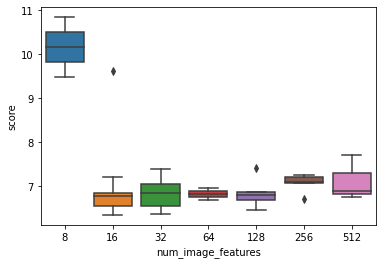

In [6]:
import seaborn as sns
sns.boxplot(data = trials_df[trials_df['augment_images']==False],x = 'num_image_features',y='score')

In [46]:
import numpy as np
import matplotlib.pyplot as plt
a=[10**(-np.random.uniform(3,4.8)) for _ in range(100) ]

In [45]:
10**-3

0.001

(array([28.,  9., 12.,  5.,  4.,  1.,  2.,  3.,  5.,  1.,  3.,  1.,  0.,
         2.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,  1.,  0.,  2.,  2.,  1.,
         1.,  1.,  4.,  2.]),
 array([1.67265017e-05, 4.80438370e-05, 7.93611722e-05, 1.10678507e-04,
        1.41995843e-04, 1.73313178e-04, 2.04630513e-04, 2.35947848e-04,
        2.67265184e-04, 2.98582519e-04, 3.29899854e-04, 3.61217189e-04,
        3.92534524e-04, 4.23851860e-04, 4.55169195e-04, 4.86486530e-04,
        5.17803865e-04, 5.49121201e-04, 5.80438536e-04, 6.11755871e-04,
        6.43073206e-04, 6.74390542e-04, 7.05707877e-04, 7.37025212e-04,
        7.68342547e-04, 7.99659882e-04, 8.30977218e-04, 8.62294553e-04,
        8.93611888e-04, 9.24929223e-04, 9.56246559e-04]),
 <BarContainer object of 30 artists>)

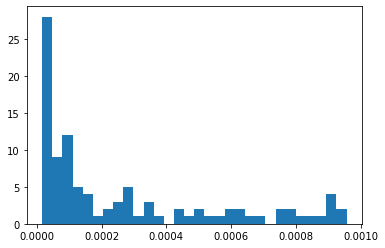

In [47]:
plt.hist(a,bins=30)

<AxesSubplot:xlabel='learning_rate', ylabel='score'>

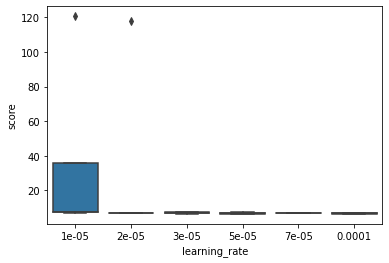

In [37]:
import seaborn as sns
sns.boxplot(data = trials_df,x = 'learning_rate',y='score')

<AxesSubplot:xlabel='weight_decay', ylabel='score'>

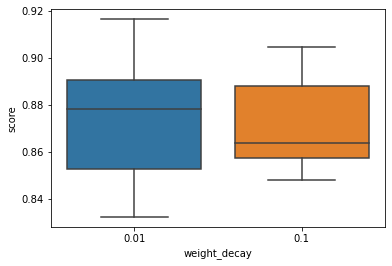

In [9]:
sns.boxplot(data = trials_df,x = 'weight_decay',y='score')

In [8]:
trials_df

,batch_size,learning_rate,weight_decay,repeats,score
0,8,0.00001,0.10,0,1.009404
1,8,0.00001,0.01,0,1.014230
2,8,0.00002,0.10,0,1.012284
3,8,0.00002,0.01,0,1.013461
4,8,0.00003,0.10,0,0.992761
5,8,0.00003,0.01,0,1.001895
6,8,0.00005,0.10,0,1.028762
7,8,0.00005,0.01,0,1.018818
8,16,0.00001,0.10,0,1.012921
9,16,0.00001,0.01,0,1.011110


In [44]:
((val['averageRating']-val['averageRating'].mean())**2).mean()

1.2757810718358051

In [50]:
1-0.5/1.27

0.6062992125984252

In [51]:
((test['averageRating']-test['averageRating'].mean())**2).mean()

1.1645053430568955